# ELEN3007 ICAO-Codes-Weather-analysis

##### This Script imports the weather data for the Chulman Airport (UELL) weather station, in Russia and then answers question outlined.

Each question that has a discussion of results is analised in the respective question markdown block before the code block.

All weather data was sourced from weatherUnderground (https://www.wunderground.com/) using their API.

The Git repo, storing this code, can be seen here: https://github.com/SoIidarity/ICAO-Weather-Analysis-Python
This main file, showing all code execution, can be seen here: https://github.com/SoIidarity/ICAO-Weather-Analysis-Python/blob/master/MainFile.ipynb


Both a PDF version and HTML version of this report are included in this submission. For an optimal viewing experience, please view the HTML version as the formatting is persistent from the Jupyter notebook. Additionally, the PDF version has HTML elements stripped out, such as some images. Alternativly, view the second Git link above to view the notebook online, through Github.

Images in this notebook are not vectors. For full vector images, in PDF form, please seen the Figures directory on Github.

First, Import libraries and such needed for program execution.

In [1]:
import numpy as np
import seaborn as sns

import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf

import scipy.stats
import matplotlib.pyplot as plt
from IPython.display import HTML, display

from io import BytesIO
from base64 import b64encode
import scipy.misc as smp

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from scipy.stats import norm

plt.rcParams['figure.figsize'] = (26, 13)


/home/chris/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


First, define some useful functions. These are used in the printing of data later on. Also used for rendering images to the HTML page.

In [2]:
def printMatrix(data):  #used to print matricies to HTML
    display(HTML(
        '<table><tr>{}</tr></table>'.format(
            '</tr><tr>'.join(
                '<td>{}</td>'
                .format('</td><td>'
                .join(str(_) for _ in row)) for row in data)
        )
    ))

def printText(text):
    display(HTML('<p>' + text + '<p>'))

def displayHTML(html):
    display(HTML(html))
    
def drawImg(img):
    b = BytesIO()
    img.save(b, format='png')
    displayHTML("<img src='data:image/png;base64,{0}'/>"
                .format(b64encode(b.getvalue()).decode('utf-8')))


## Question 1 
Import data from text files. These are stored as csvs in the "Data" directory in the repo. This CSV is formatted as: {Unit Timestamp, max Temp, avg Temp, min Temp}. Each CSV is read into a matrix. These matricies are then added to a vector so they can be itterated through later on.

In [3]:
w1995 = np.genfromtxt('Data/1995.csv', delimiter=',')
w2000 = np.genfromtxt('Data/2000.csv', delimiter=',')
w2005 = np.genfromtxt('Data/2005.csv', delimiter=',')
w2010 = np.genfromtxt('Data/2010.csv', delimiter=',')
w2015 = np.genfromtxt('Data/2015.csv', delimiter=',')

weatherData = [w1995, w2000, w2005, w2010, w2015]

## Question 2
Next, identify the minimum, maximum, mean and standard deviation for each year. As the matricies are in a vector, we can do this sequentially in a loop. These outputs are produced in a matrix, where the columns are the years (1995,2000,2005,2010,2015) and the rows are the minimum, maximum, mean and standard deviation for each year. This can be seen in the table below.

The mean is calculated with the standard numpy mean equation that calculates the following. This is the average of the data set:
$$\bar{x} = \frac{1}{n}\left (\sum_{i=1}^n{x_i}\right ) = \frac{x_1+x_2+\cdots +x_n}{n}$$

Standard deviation is used to quantify variance in the data, as defined by:
$$s = \sqrt{\frac{\sum_{i=1}^N (x_i - \overline{x})^2}{N-1} }$$


### Comment on findings
The minimum, maximum, mean and standard deviations are very similar for each year. this is to be expected as they were taken from the same location. However, as time went on over the past 20 years, it seems that the averages became walmer with both the maximums and minimums increasing over time. There are outlyers in this trend as seen in 2010's minimum tempreture. This trend is also verified by looking at the mean where each year is shown to be getting walmer.

The high standard deviation seen is accounted for by the large tempreture changes during the course of the year. A delta between the maximum of 37 and minimum of -45 of 82 degrees is rather high.

In [4]:
dataValues = np.zeros((4, 5))
counter = 0;
for year in weatherData:
    dataValues[0, counter] = year[:, 3].min()  #max of max values
    dataValues[1, counter] = year[:, 1].max()  #min of min values
    dataValues[2, counter] = round(year[:, 2].mean(), 2)  #average of average values
    dataValues[3, counter] = round(year[:, 2].std(), 2)  #Standard deviation of average values
    counter = counter + 1;




displayHTML(pd.DataFrame(dataValues,
                         columns = ['1995', '2000', '2005', '2010', '2015'],
                         index = ['Minimum', 'Maximum', 'Mean', 'Standard Deviation']).to_html())


,1995,2000,2005,2010,2015
Minimum,-45.00,-45.00,-41.00,-45.00,-42.00
Maximum,29.00,37.00,30.00,28.00,33.00
Mean,-6.65,-6.83,-6.39,-6.83,-5.43
Standard Deviation,18.01,16.56,17.08,18.10,16.53


## Question 3
Each Years probability distribution functions are now plotted, for each year, on the same set of axes. To achive this, a fixed plot of univariate distributions is generated. This is done with the Seaborn displot function.

This value is calculated by using the seaborn distplot function that recreates the standard PDF equation as:
$$\operatorname{E}[X] = \int_{-\infty}^\infty x\,f(x)\,dx$$

### Comment on findings
Each year has a similar general probobility distribution function. They apear to be close to normal in shape. general average trends can also be seen through this graph such as 2005 had higher distribution of both highs and lows, with a lower distribution in the middel. This indicates more extreme weather during this year.


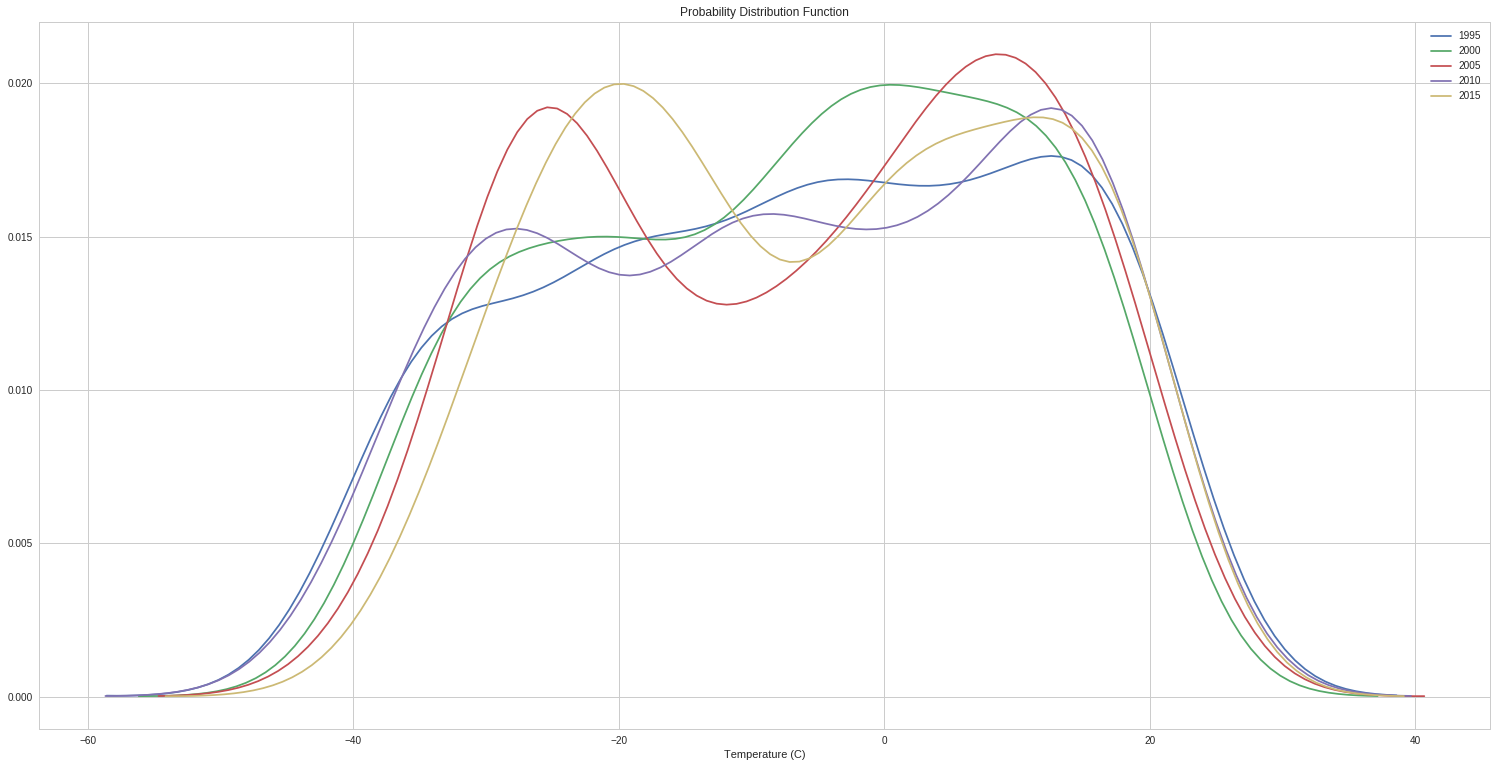

In [5]:
sns.set_style('whitegrid')
counter = 0;
for year in weatherData:
    sns.distplot(year[:, 2], hist=False,
                 label=1995 + counter * 5,  
                 axlabel="Temperature (C)")
    counter = counter + 1;
plt.title('Probability Distribution Function')
plt.savefig("Figures/probability distribution function.pdf")
plt.show()


## Question 4
The cross-correlation between each year’s annual temperatures is now calculated. This is shown as a matrix output
Note here that we are slicing the data on each year to ignore the leap year in 2000. This is done as the correlation needs matricies of the same dimension.

Additionally note that we need to normalise the data. This is the same as using the numpy corrfoef function.

TO calculate this, the numpy correlate function was used. This function makes use of this equation:

$$(f \star g)(\tau)\ \stackrel{\mathrm{def}}{=} \int_{-\infty}^{\infty} f^*(t)\ g(t+\tau)\,dt$$

### Comment on findings
Through the cross-correlation of the presented data, one can see the relationship between each years weather. The closer these values are to 1, the more closely correlated the data is. The highest correlation is seen between 2010 and 1995 intrestingly enough with a 94% correlation. The main diagonal of 1's indicates the full correlation, with each year corelated against its self.

In [6]:
autoCorrelation = np.zeros((5, 5))
for x in range(0, 5):
    for y in range(0, 5):
        a = weatherData[x][0:365, 2]
        b = weatherData[y][0:365, 2]
        a = (a - np.mean(a)) / (np.std(a) * len(a))
        b = (b - np.mean(b)) / (np.std(b))
        autoCorrelation[x, y] = np.correlate(a, b)
columns = ['1995', '2000', '2005', '2010', '2015']
index = ['1995', '2000', '2005', '2010', '2015']

displayHTML(pd.DataFrame(autoCorrelation, columns, index).to_html())


,1995,2000,2005,2010,2015
1995,1.000000,0.918720,0.918722,0.940312,0.922096
2000,0.918720,1.000000,0.917592,0.921972,0.925752
2005,0.918722,0.917592,1.000000,0.940042,0.932908
2010,0.940312,0.921972,0.940042,1.000000,0.933412
2015,0.922096,0.925752,0.932908,0.933412,1.000000


## Question 5
The autocorrelation function for each year’s data, where τ ranges from 0 to 364 is now generated.

Confidence intervals are drawn as a cone. By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation and not a statistical fluke.

First, each Autocorrelation is drawn on its own graph. After, they are overlayed.

Autocorrelation is found through the use of the plot_acf function from the tsaplots statistics library. From a signal processing point of view, this can be seen as:

$$R_{ff}(\tau) = (f * g_{-1}(\overline{f}))(\tau) = \int_{-\infty}^\infty f(u+\tau)\overline{f}(u)\, {\rm d}u = \int_{-\infty}^\infty f(u)\overline{f}(u-\tau)\, {\rm d}u$$

### Comment on findings
This autocorrelation shows how each year is related to a time-shifted version of itself. This can be seen as an effective convolution process. From this, one can see how each part of the year is related to the rest of the year for a given shift amount τ. For example, at τ=0, the magnitude is 1. At this time, no shifting has occurred. At approximately τ=150, there is the highest negative correlation seen. This is due to the correlation between the middle of summer and winter of the two data sets.

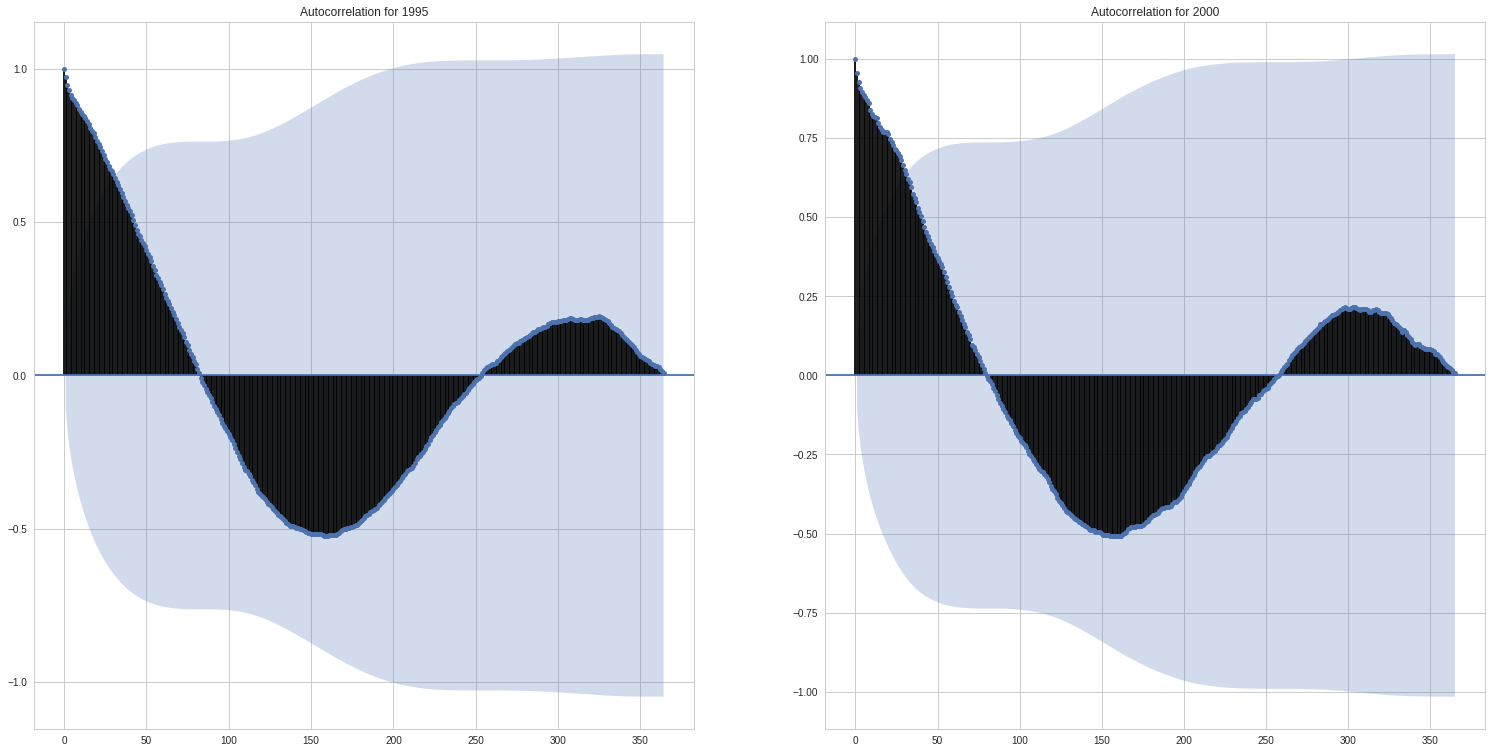

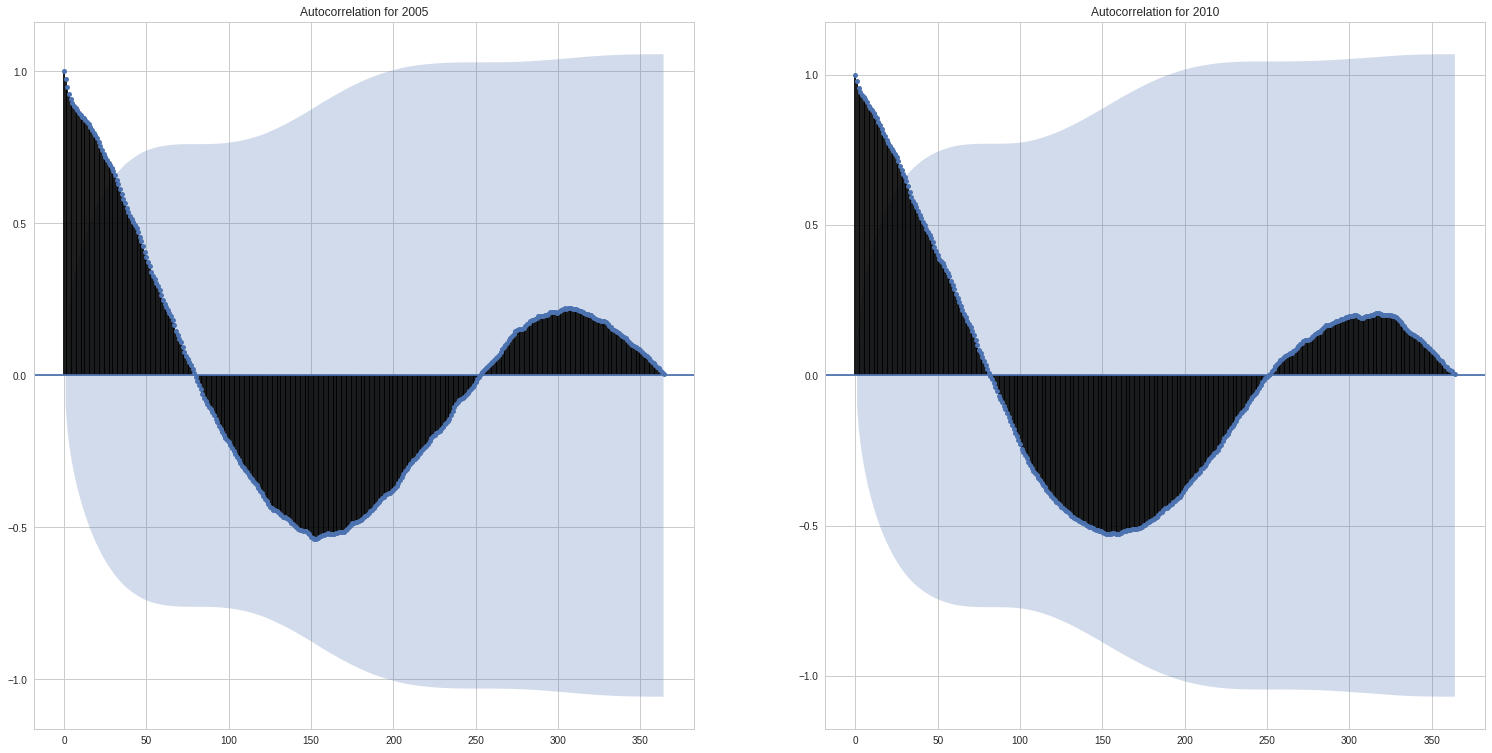

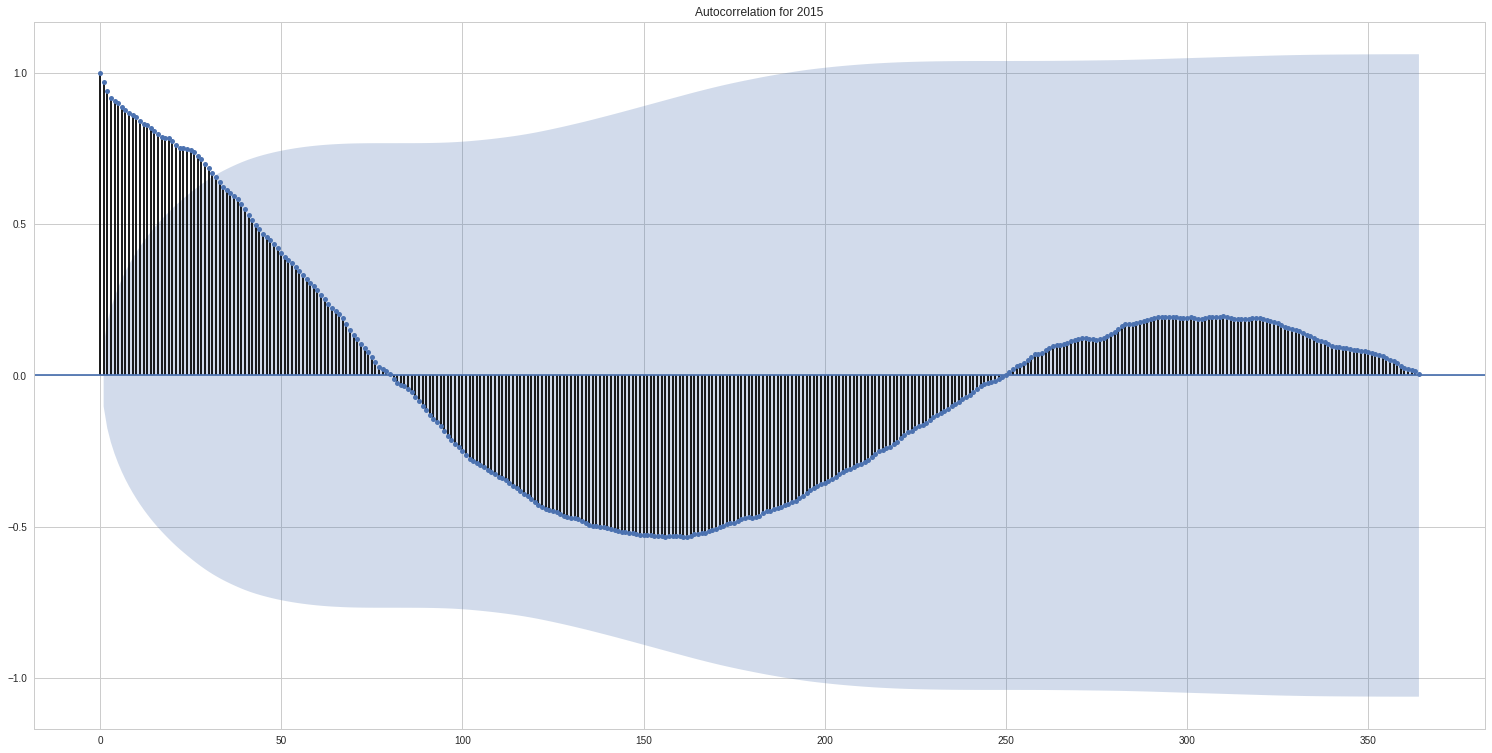

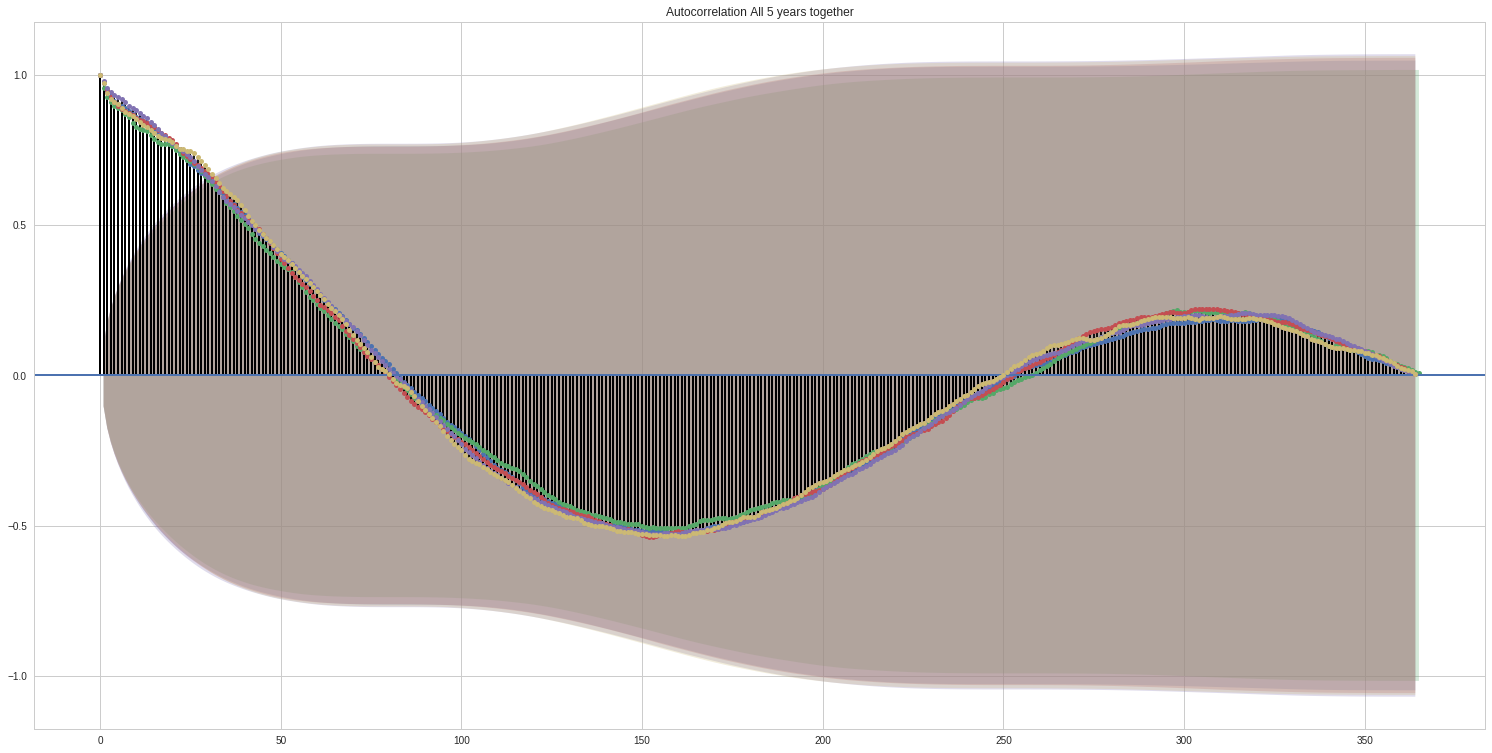

In [7]:
counter = 0;
for year in weatherData:

    if (counter == 0):  #on the first loop, generate the subplots
        fig, axs = plt.subplots(1, 2)
    
    if counter == 4:  # if we are at the last figure, we want it to be on its own line
        plot_acf(year[:, 2], 
                 title = "Autocorrelation for {}"
                 .format(1995 + 5 * counter))
        plt.savefig("Figures/Autocorrelation for 2015.pdf")
        plt.show()
    else:
        plot_acf(year[:, 2], 
                 title = "Autocorrelation for {}"
                 .format(1995 + 5 * counter), 
                 ax=axs[counter % 2])
    if counter % 2 == 1:  # every two figures, we need to generate a new row
        
        plt.savefig("Figures/Autocorrelation for {} and {}.pdf"
                    .format(1995 + 5 * counter-5,1995 + 5 * counter))
        plt.show()
        if (counter < 2):  #a new sub plot is needed on second row
            fig, axs = plt.subplots(1, 2)
    counter = counter + 1

counter = 0;
fig, axs = plt.subplots(1, 1)
for year in weatherData:
    
    plot_acf(year[:, 2], 
             title = "Autocorrelation All 5 years together"
             .format(1995 + 5 * counter),
            ax=axs)
plt.savefig("Figures/All years Autocorrelation.pdf")
plt.show()



## Question 6.a &6.b
Next, each year, temp is broken down into subdivisions in the range:
$$[minimum-0.1=t_0,maximum+0.1=t_10]$$
into ten equal intervals. This is then used to generate 10 intervals, as:
$$[[t_0,t_1],...,[t_9,t_10]]$$

1. binCorours are predefined RGB values, given in the question
2. The linspace function below is used to generate a set of numbers with equal distributions between the min and max data for each year.
3. Digitisation is used to put the data into the respective buckets. This can then be used later on when the graphs are drawn
4. generate a matrix to store the image colour values
5. iterate over each day of the year*2. double as we need to have two rows for each day(high and low)
6. set the current iteration-1 row of pixels to the low digitised index value from colour matrix provided. 
7. same as above, but for the current iterator for the high values provided
8. convert matrix to image
9. draw image to screen

The output below this code shows first the bins for each year, for question 6.a. Then, the blankets are drawn for question 6.b



,Low bin,High bin
0,-45.100000,-37.100000
1,-38.077778,-29.744444
2,-31.055556,-22.388889
3,-24.033333,-15.033333
4,-17.011111,-7.677778
5,-9.988889,-0.322222
6,-2.966667,7.033333
7,4.055556,14.388889
8,11.077778,21.744444
9,18.100000,29.100000



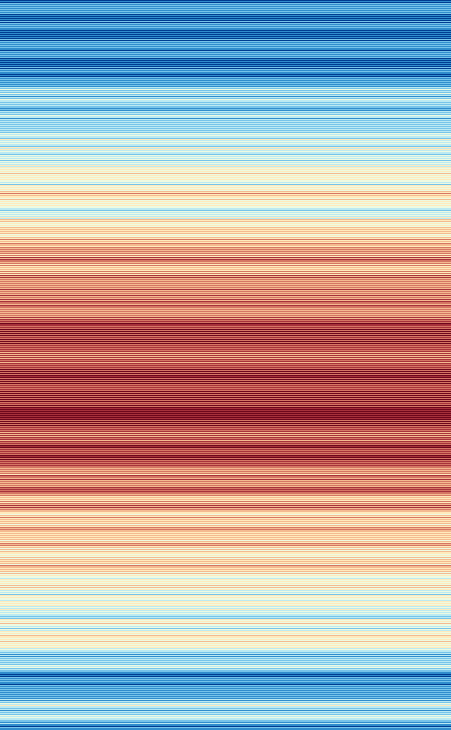

,Low bin,High bin
0,-45.100000,-36.100000
1,-38.188889,-27.966667
2,-31.277778,-19.833333
3,-24.366667,-11.700000
4,-17.455556,-3.566667
5,-10.544444,4.566667
6,-3.633333,12.700000
7,3.277778,20.833333
8,10.188889,28.966667
9,17.100000,37.100000



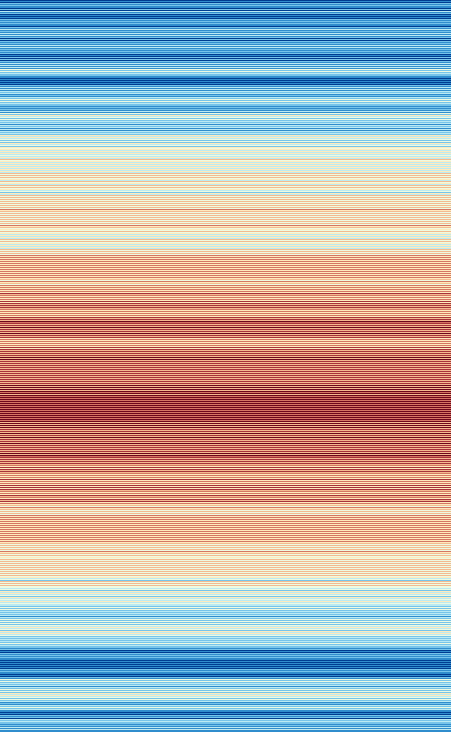

,Low bin,High bin
0,-41.100000,-36.100000
1,-34.522222,-28.744444
2,-27.944444,-21.388889
3,-21.366667,-14.033333
4,-14.788889,-6.677778
5,-8.211111,0.677778
6,-1.633333,8.033333
7,4.944444,15.388889
8,11.522222,22.744444
9,18.100000,30.100000



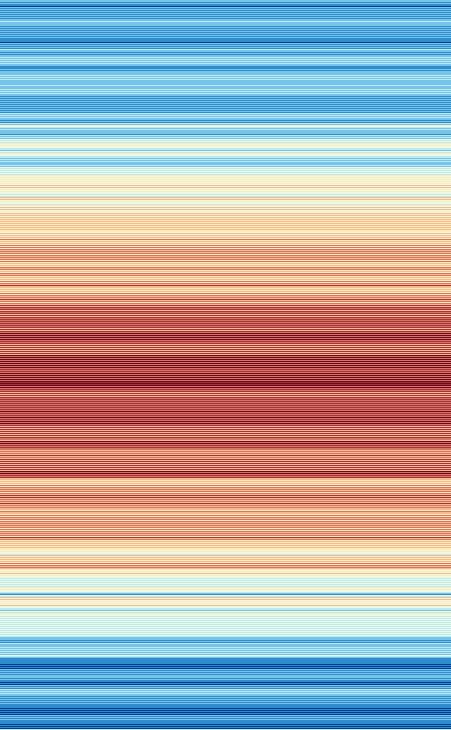

,Low bin,High bin
0,-45.100000,-39.100000
1,-38.188889,-31.633333
2,-31.277778,-24.166667
3,-24.366667,-16.700000
4,-17.455556,-9.233333
5,-10.544444,-1.766667
6,-3.633333,5.700000
7,3.277778,13.166667
8,10.188889,20.633333
9,17.100000,28.100000



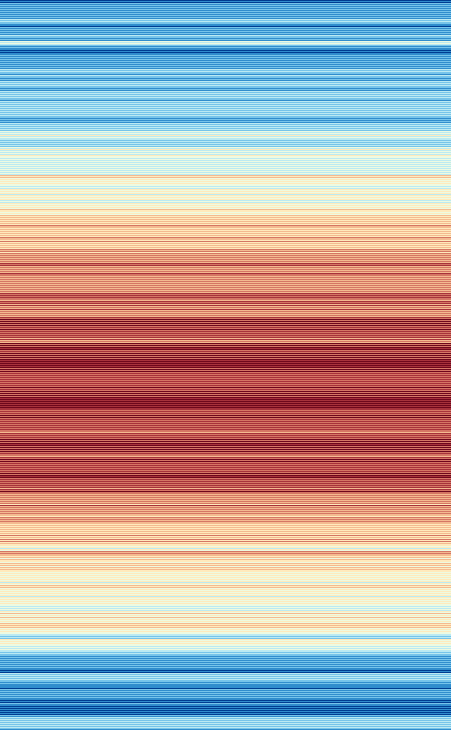

,Low bin,High bin
0,-42.100000,-36.100000
1,-35.522222,-28.411111
2,-28.944444,-20.722222
3,-22.366667,-13.033333
4,-15.788889,-5.344444
5,-9.211111,2.344444
6,-2.633333,10.033333
7,3.944444,17.722222
8,10.522222,25.411111
9,17.100000,33.100000



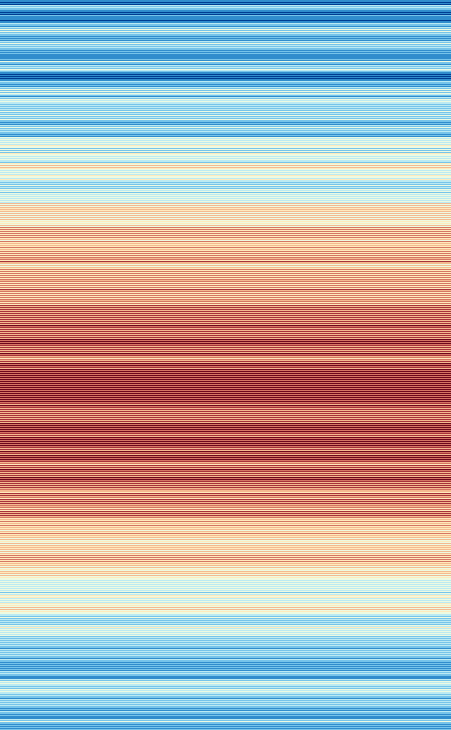

In [10]:
binColours = [[0.139681, 0.311666, 0.550652], [0.276518, 0.539432, 0.720771],
              [0.475102, 0.695344, 0.802081], [0.670448, 0.803486, 0.824645],
              [0.809791, 0.848259, 0.777550], [0.861927, 0.803423, 0.673050],
              [0.830690, 0.667645, 0.546349], [0.742023, 0.475176, 0.424114],
              [0.613033, 0.281826, 0.306352], [0.450385, 0.157961, 0.217975]]
counter = 0;
for year in weatherData:
    num = 10
    binsLow = np.linspace(year[:, 3].min() - 0.1, year[:, 3].max() + 0.1, num)
    binsHigh = np.linspace(year[:, 1].min() - 0.1, year[:, 1].max() + 0.1, num)

    digitizedLow = np.digitize(year[:, 3], binsLow)  #put the data into the bins
    digitizedHigh = np.digitize(year[:, 3], binsHigh)

    rows = 2 * len(year[:, 3])
    image = np.zeros((rows, 451, 3))  #make a matrix to store the image
#itterate over each year's values from the above values and set pixels colours
    for x in range(0, rows, 2):  
        image[x - 1, 0:451] = binColours[int(digitizedLow[int(x / 2)])]
        image[x, 0:451] = binColours[int(digitizedHigh[int(x / 2)])]
    printText("Tempreture blanket for year: {}".format(1995 + 5 * counter))

    displayHTML(pd.DataFrame(np.column_stack((binsLow.reshape(10, 1),
                                              (binsHigh.reshape(10, 1)))),
                             columns=["Low bin", "High bin"]).to_html())

    outputImage = smp.toimage(image)
    outputImage.save('WeatherBlancketsOutput/{}.jpg'.format(1995 + 5 * counter))
    drawImg(outputImage)  #Draw image to screen, using custom draw function to put output in window
    counter = counter + 1;


## Question 7
Next, a surface plot of a stochastic process is generated. For this, avarages are generated over all 5 sets of data for each year, as well as a standard diviation for each day. Next, a linear space is generated representing the posible tempreture ranges. finally, the PDF is found then plotted in 3D.

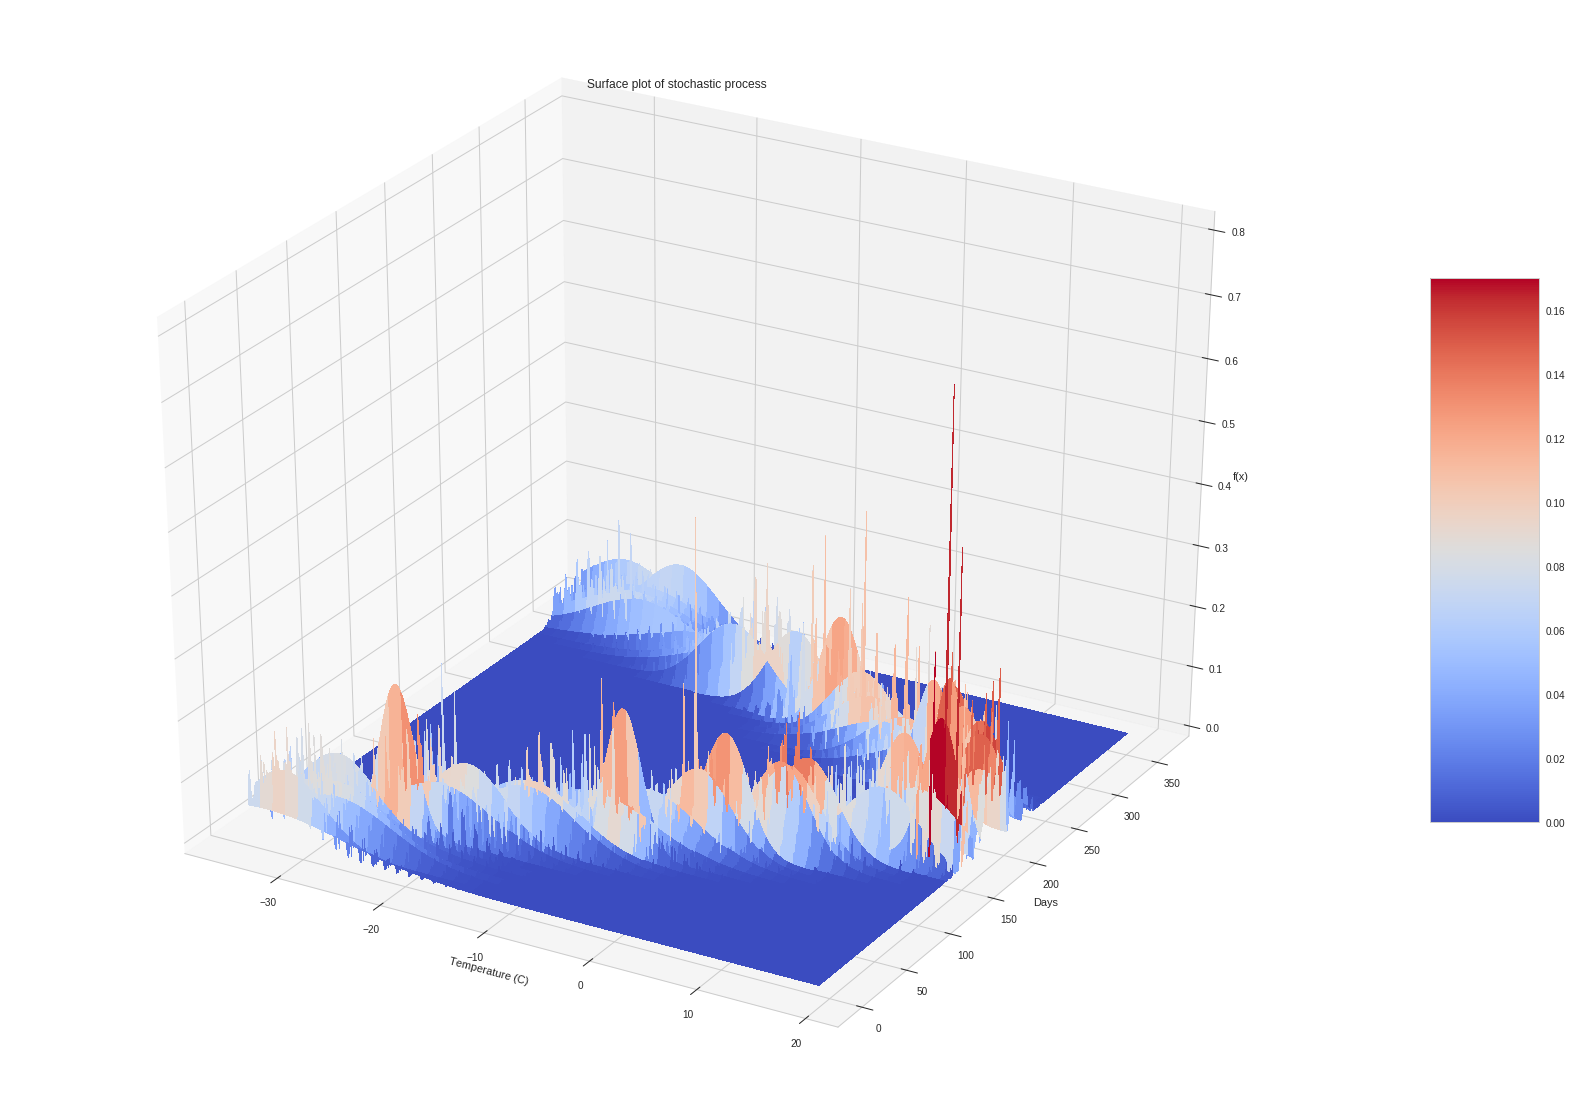

In [9]:
plt.rcParams['figure.figsize'] = (30, 20)  #Make the figure for this question bigger

#define the variables to store the mean, std deviation, 
# range for each day(temp), pdfs and a vector for number of days
meanDay = np.zeros((365, 1))
stdDay = np.zeros((365, 1))
dayArray = np.zeros((5, 1))
pdf = np.zeros((365, 365))
dayRange = range(0, 365, 1)

for day in dayRange:
    for inx, year in enumerate(weatherData):
        dayArray[inx, 0] = year[:, 2][day]
    meanDay[day] = dayArray.mean()  #calculate the mean
    stdDay[day] = dayArray.std()  # calculate the standard deviation

#generate a linear space of all days in the region, for the min to max temp
tempretureSpace = np.linspace(meanDay.min(), 
                              meanDay.max(), 
                              len(weatherData[0][:, 2]))

#itterate over the days again, now generating the pdf
for day in dayRange:
    pdf[day, :] = norm.pdf(tempretureSpace, 
                           meanDay[day], 
                           stdDay[day])

#convert the values to a meshgrid 
# (return coordinate matrices from coordinate vectors)
tempretureSpace, dayRange = np.meshgrid(tempretureSpace, dayRange)

#finally, plot it as a 3d surf
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(tempretureSpace,
                       dayRange,
                       pdf,
                       cmap=cm.coolwarm,
                       linewidth=0,
                       antialiased=False)

ax.set_xlabel('Temperature (C)')
ax.set_ylabel('Days')
ax.set_zlabel('f(x)')

#add a colour bar on the side to see magnitudes
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('Surface plot of stochastic process')
plt.savefig("Figures/surface plot of stochastic process.pdf")
plt.show()
